## Cincinnati Logistic and Poisson Regression (Proof of Concept)
##### Code by Drew Gobbi 12/3/2019

### Import Packages and Data Cleaning 

In [15]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads
import pickle
from sklearn.preprocessing import StandardScaler

In [16]:
pkl_in_Cin = open('countMedicalFacilitiesWithin2milesCinbyTract.pkl', 'rb')

fac = pickle.load(pkl_in_Cin)

In [17]:
fac.head()

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi,geometry
0,52.00,3,1,7,6,0,1,2,1,1,9,9,2,0,0,13,1,16,"POLYGON ((-84.43168 39.15720, -84.43177 39.156..."
1,53.01,2,1,7,6,0,1,2,1,1,9,7,2,0,0,15,0,13,"POLYGON ((-84.42516 39.15576, -84.42513 39.155..."
2,53.02,1,1,4,5,0,1,3,1,1,7,8,1,0,0,12,0,12,"POLYGON ((-84.40766 39.15576, -84.40748 39.155..."
3,54.00,2,1,7,6,0,1,2,1,1,9,6,2,0,0,15,0,12,"POLYGON ((-84.42096 39.16456, -84.41972 39.163..."
4,55.00,1,1,2,4,0,1,3,0,1,6,10,1,0,0,11,0,11,"MULTIPOLYGON (((-84.39309 39.16722, -84.39303 ..."


In [18]:
fac.dtypes

CensusTract                        object
HospitalsGeneralCount2mi            int64
HospitalsPsychCount2mi              int64
SurgicalCentersCount2mi             int64
UrgentCareCount2mi                  int64
WomensClinicsCount2mi               int64
PainManagementCount2mi              int64
PhysicalTherapyCount2mi             int64
MentalFacilitiesCount2mi            int64
SubstanceAbuseCount2mi              int64
OtherMedicalFacilitesCount2mi       int64
NursingAssistedLiveCount2mi         int64
HospiceCount2mi                     int64
HospitalsChildCount2mi              int64
ChildFacilitiesCount2mi             int64
PharmCount2mi                       int64
DrugDropCount2mi                    int64
NaloxoneDistribCount2mi             int64
geometry                         geometry
dtype: object

In [5]:
pdb = pd.read_csv('pdb2019trv6_us.csv',encoding = "ISO-8859-1")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (286) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
cin = pdb[(pdb['State_name'] == 'Ohio') ]
print(cin)
print(cin.columns)

             GIDTR  State State_name  County     County_name   Tract  Flag  \
50530  39001770100     39       Ohio       1    Adams County  770100   NaN   
50531  39001770200     39       Ohio       1    Adams County  770200   NaN   
50532  39001770300     39       Ohio       1    Adams County  770300   NaN   
50533  39001770400     39       Ohio       1    Adams County  770400   NaN   
50534  39001770500     39       Ohio       1    Adams County  770500   NaN   
...            ...    ...        ...     ...             ...     ...   ...   
53477  39175938100     39       Ohio     175  Wyandot County  938100   NaN   
53478  39175938200     39       Ohio     175  Wyandot County  938200   NaN   
53479  39175938300     39       Ohio     175  Wyandot County  938300   NaN   
53480  39175938400     39       Ohio     175  Wyandot County  938400   NaN   
53481  39175938500     39       Ohio     175  Wyandot County  938500   NaN   

       Num_BGs_in_Tract  LAND_AREA  AIAN_LAND  ...  \
50530    

In [7]:
var = ['Med_HHD_Inc_ACS_13_17', 'Median_Age_ACS_13_17','pct_College_ACS_13_17',
       'pct_Not_HS_Grad_ACS_13_17','pct_NoHealthIns_65P_ACS_13_17',
       'pct_NH_White_alone_ACS_13_17','pct_NH_AIAN_alone_ACS_13_17', 'pct_Males_ACS_13_17', 'pct_Pop_18_24_ACS_13_17',
       'pct_Pop_65plus_ACS_13_17','pct_Prs_Blw_Pov_Lev_ACS_13_17', 'pct_One_Health_Ins_ACS_13_17'
       ,'pct_Two_Plus_Health_Ins_ACS_13_17','Civ_labor_16plus_ACS_13_17','pct_Civ_unemp_16plus_ACS_13_17',
        'Civ_labor_16_24_ACS_13_17','pct_Civ_unemp_16_24_ACS_13_17','Civ_labor_25_44_ACS_13_17',
       'Civ_labor_45_64_ACS_13_17','pct_Civ_unemp_45_64_ACS_13_17','pct_PUB_ASST_INC_ACS_13_17','Tract']

"""var = ['Med_HHD_Inc_ACS_13_17', 'pct_College_ACS_13_17', 'pct_Males_ACS_13_17', 'pct_Pop_18_24_ACS_13_17',
      'pct_Pop_25_44_ACS_13_17', 'Tract']"""

"var = ['Med_HHD_Inc_ACS_13_17', 'pct_College_ACS_13_17', 'pct_Males_ACS_13_17', 'pct_Pop_18_24_ACS_13_17',\n      'pct_Pop_25_44_ACS_13_17', 'Tract']"

In [22]:
cin = cin.filter(var)
cin.Tract=cin.Tract.astype(float)
print(cin['Civ_labor_45_64_ACS_13_17'])


50530     732.0
50531     731.0
50532    1277.0
50533     697.0
50534     457.0
          ...  
53477     941.0
53478     748.0
53479     531.0
53480     608.0
53481     781.0
Name: Civ_labor_45_64_ACS_13_17, Length: 2952, dtype: float64


ValueError: could not convert string to float: '$32,911'

In [10]:
#align labeling of tracts between fac and pdb - need codes w/o decimals
fac.CensusTract = fac.CensusTract.astype(float)
#fac.CensusTract = int(fac.CensusTract)
fac.CensusTract = fac.CensusTract *100

print(fac)

     CensusTract  HospitalsGeneralCount2mi  HospitalsPsychCount2mi  \
0         5200.0                         3                       1   
1         5301.0                         2                       1   
2         5302.0                         1                       1   
3         5400.0                         2                       1   
4         5500.0                         1                       1   
..           ...                       ...                     ...   
121       4702.0                         0                       0   
122       4800.0                         0                       0   
123       4900.0                         1                       0   
124       5000.0                         2                       0   
125       5100.0                         1                       0   

     SurgicalCentersCount2mi  UrgentCareCount2mi  WomensClinicsCount2mi  \
0                          7                   6                      0   
1        

In [11]:
df = fac.merge(cin, left_on='CensusTract', right_on='Tract')

In [20]:
df

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,...,pct_Prs_Blw_Pov_Lev_ACS_13_17,pct_One_Health_Ins_ACS_13_17,Civ_labor_16plus_ACS_13_17,Civ_labor_16_24_ACS_13_17,pct_Civ_unemp_16_24_ACS_13_17,Civ_labor_25_44_ACS_13_17,Civ_labor_45_64_ACS_13_17,pct_Civ_unemp_45_64_ACS_13_17,pct_PUB_ASST_INC_ACS_13_17,Tract
0,5200.0,3,1,7,6,0,1,2,1,1,...,4.27,87.95,2465.0,271.0,0.00,1580.0,531.0,3.77,0.67,5200.0
1,5200.0,3,1,7,6,0,1,2,1,1,...,7.37,84.84,2688.0,428.0,0.00,1718.0,458.0,12.88,0.33,5200.0
2,5200.0,3,1,7,6,0,1,2,1,1,...,24.18,78.57,1675.0,503.0,8.35,658.0,467.0,8.78,5.83,5200.0
3,5301.0,2,1,7,6,0,1,2,1,1,...,13.94,85.84,2648.0,455.0,7.69,1498.0,581.0,1.72,0.64,5301.0
4,5302.0,1,1,4,5,0,1,3,1,1,...,12.41,72.30,2006.0,392.0,1.53,1095.0,393.0,0.00,1.01,5302.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,5000.0,2,0,6,5,0,0,1,2,0,...,5.44,86.99,3278.0,537.0,6.52,1796.0,786.0,0.00,1.96,5000.0
380,5000.0,2,0,6,5,0,0,1,2,0,...,25.46,76.12,992.0,180.0,23.33,450.0,330.0,12.42,5.81,5000.0
381,5100.0,1,0,4,5,0,1,2,1,1,...,75.65,67.40,368.0,82.0,0.00,164.0,90.0,17.78,18.86,5100.0
382,5100.0,1,0,4,5,0,1,2,1,1,...,5.16,90.41,1469.0,133.0,2.26,852.0,422.0,0.00,0.68,5100.0


In [28]:
print(df['Civ_labor_25_44_ACS_13_17'])
#df.shape

0      1580.0
1      1718.0
2       658.0
3      1498.0
4      1095.0
        ...  
379    1796.0
380     450.0
381     164.0
382     852.0
383     771.0
Name: Civ_labor_25_44_ACS_13_17, Length: 384, dtype: float64


In [12]:
df.columns

Index(['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi',
       'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'geometry',
       'Med_HHD_Inc_ACS_13_17', 'Median_Age_ACS_13_17',
       'pct_College_ACS_13_17', 'pct_Not_HS_Grad_ACS_13_17',
       'pct_NoHealthIns_65P_ACS_13_17', 'pct_NH_White_alone_ACS_13_17',
       'pct_NH_AIAN_alone_ACS_13_17', 'pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17', 'pct_Pop_65plus_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17', 'pct_One_Health_Ins_ACS_13_17',
       'Civ_labor_16plus_ACS_13_17', 'Civ_labor_16_24_ACS_13_17',
       'pct_Civ_unemp_16_24_ACS_

In [21]:

scaler = StandardScaler()
scaler.fit(df)

df = scaler.transform(df)
print(df)

KeyError: ('CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi', 'SurgicalCentersCount2mi', 'UrgentCareCount2mi', 'WomensClinicsCount2mi', 'PainManagementCount2mi', 'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi', 'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi', 'NursingAssistedLiveCount2mi', 'HospiceCount2mi', 'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi', 'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'Med_HHD_Inc_ACS_13_17', 'Median_Age_ACS_13_17', 'pct_College_ACS_13_17', 'pct_Not_HS_Grad_ACS_13_17', 'pct_NoHealthIns_65P_ACS_13_17', 'pct_NH_White_alone_ACS_13_17', 'pct_NH_AIAN_alone_ACS_13_17', 'pct_Males_ACS_13_17', 'pct_Pop_18_24_ACS_13_17', 'pct_Pop_65plus_ACS_13_17', 'pct_Prs_Blw_Pov_Lev_ACS_13_17', 'pct_One_Health_Ins_ACS_13_17', 'Civ_labor_16plus_ACS_13_17', 'Civ_labor_16_24_ACS_13_17', 'pct_Civ_unemp_16_24_ACS_13_17', 'Civ_labor_25_44_ACS_13_17', 'Civ_labor_45_64_ACS_13_17', 'pct_Civ_unemp_45_64_ACS_13_17', 'pct_PUB_ASST_INC_ACS_13_17')

In [23]:
fac.columns

Index(['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi',
       'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'geometry'],
      dtype='object')

### Get EMS Data

In [72]:
pip install sodapy

Note: you may need to restart the kernel to use updated packages.


In [24]:
from sodapy import Socrata
client = Socrata("data.cincinnati-oh.gov", None)
results = client.get("3gx7-se9a", limit=11000)

# Convert to pandas DataFrame
ems = pd.DataFrame.from_records(results)

In [141]:
ems.to_csv('cincy_ems.csv')

In [25]:
ems.head()

,address_x,latitude_x,longitude_x,agency,create_time_incident,disposition_text,event_number,incident_type_id,priority,closed_time_incident,beat,community_council_neighborhood,district,incident_type_desc,priority_color,arrival_time_primary_unit,dispatch_time_primary_unit
0,16XX CALIFORNIA AV,39.1754784436823,-84.4670395218747,CPD,2017-05-16T20:35:05.000,BC: BROADCAST,CPD170516001810,DRUG,3,2017-05-16T20:40:39.000,P451,BOND HILL,4,NaN,NaN,NaN,NaN
1,16XX ILIFF AV,39.1177910001195,-84.580431,CPD,2017-10-13T21:25:58.000,INV: INV,CPD171013002052,DRUG,7,2017-10-13T22:16:51.000,P321,WEST PRICE HILL,3,DRUG ACTIVITY,YELLOW,2017-10-13T21:58:24.000,2017-10-13T21:44:59.000
2,21XX CLARA ST,39.1227367321796,-84.5518912925694,CPD,2017-03-22T20:41:51.000,AST: ASSIST,CPD170322001510,HEROINP-COMBINED,2,2017-03-23T02:13:01.000,P341,SOUTH FAIRMOUNT,3,NaN,NaN,2017-03-22T21:04:18.000,2017-03-22T20:52:13.000
3,13XX VINE ST,39.1095160001195,-84.515049,CPD,2017-12-13T02:29:05.000,INV: INV,CPD171213000116,DRUG,7,2017-12-13T02:44:10.000,P121,OTR,1,DRUG ACTIVITY,YELLOW,2017-12-13T02:31:36.000,2017-12-13T02:30:06.000
4,2XX W MCMICKEN AV,39.1194960001195,-84.524441,CPD,2017-09-05T16:28:05.000,ADV:ADVISED,CPD170905001184,DRUGR,35,2017-09-05T16:28:05.000,P121,OTR,1,DRUG COMPLAINT REFERRAL,PURPLE,NaN,NaN


In [26]:
ems.longitude_x = ems.longitude_x.astype(float)
ems.latitude_x = ems.latitude_x.astype(float)

In [27]:
ems_gdf = gpd.GeoDataFrame(
    ems, geometry=gpd.points_from_xy(ems.longitude_x, ems.latitude_x))

In [28]:
cin_gdf = gpd.GeoDataFrame(df, geometry=df.geometry)

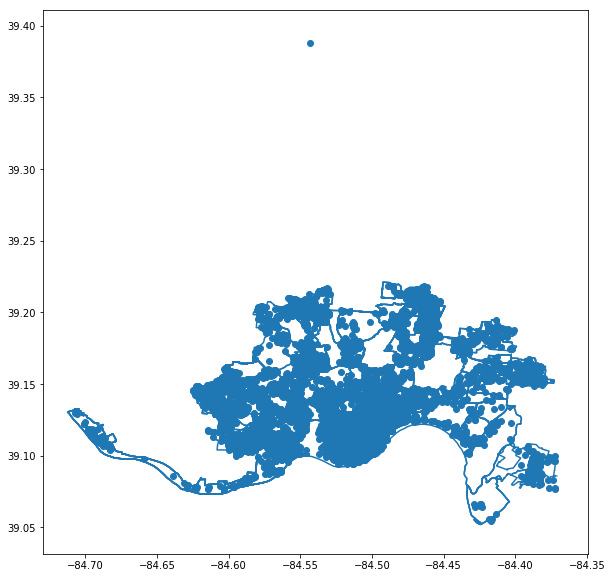

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ems_gdf.plot(ax=ax)
cin_gdf.boundary.plot(ax=ax)

In [30]:
out = pd.DataFrame()
for i in range(len(cin_gdf)):
    temp = ems_gdf[ems_gdf.within(cin_gdf.loc[i,'geometry'])]
    temp['tract'] = cin_gdf.loc[i,'Tract']
    out = pd.concat([out, temp])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [37]:
len(out)

37072

In [31]:
len(ems)

10498

In [32]:
out.closed_time_incident = pd.to_datetime(out.closed_time_incident)

In [33]:
out['year_month'] = out.closed_time_incident.dt.year.astype(float) + out.closed_time_incident.dt.month.astype(float)/100

In [34]:
out.head()

,address_x,latitude_x,longitude_x,agency,create_time_incident,disposition_text,event_number,incident_type_id,priority,closed_time_incident,beat,community_council_neighborhood,district,incident_type_desc,priority_color,arrival_time_primary_unit,dispatch_time_primary_unit,geometry,tract,year_month
89,27XX MADISON RD,39.145535,-84.440570,CPD,2017-06-07T13:22:45.000,INV: INV,CPD170607000895,DRUG,7,2017-06-07 13:52:13,P222,HYDE PARK - OAKLEY,2,DRUG ACTIVITY,YELLOW,2017-06-07T13:35:34.000,2017-06-07T13:29:19.000,POINT (-84.44057 39.14553),5200.0,2017.06
1022,MADISON RD / EDWARDS RD,39.145584,-84.441808,CPD,2017-06-07T00:44:41.000,SOW: SENT ON WAY,CPD170607000050,DRUG,7,2017-06-07 01:23:36,P222,HYDE PARK - OAKLEY,2,DRUG ACTIVITY,YELLOW,2017-06-07T00:58:58.000,2017-06-07T00:58:57.000,POINT (-84.44181 39.14558),5200.0,2017.06
1865,38XX MILLSBRAE AV,39.149455,-84.440186,CPD,2017-06-21T20:34:49.000,ADV:ADVISED,CPD170621001651,DRUGR,35,2017-06-21 20:34:49,P222,OAKLEY,2,DRUG COMPLAINT REFERRAL,PURPLE,NaN,NaN,POINT (-84.44019 39.14946),5200.0,2017.06
3017,ATLANTIC AV / MILLSBRAE AV,39.148527,-84.439880,CPD,2017-10-23T22:18:45.000,ADV:ADVISED,CPD171023001616,DRUGR,35,2017-10-23 22:18:45,P222,OAKLEY,2,DRUG COMPLAINT REFERRAL,PURPLE,NaN,NaN,POINT (-84.43988 39.14853),5200.0,2017.10
3714,27XX MADISON RD,39.146658,-84.441568,CPD,2017-04-05T09:36:30.000,ARR: ARREST,CPD170405000402,HEROINP-COMBINED,2,2017-04-05 11:51:58,P222,OAKLEY,2,NaN,NaN,2017-04-05T09:40:12.000,2017-04-05T09:38:21.000,POINT (-84.44157 39.14666),5200.0,2017.04


In [35]:
mt = out.groupby([out['year_month'],  out['tract']]).agg({'count'})

In [36]:
mt = mt['event_number']
mt.reset_index(inplace=True)

mt.rename(columns={'count': 'ems_call'}, inplace=True)

In [37]:
mt.head()

,year_month,tract,ems_call
0,2017.01,200.0,48
1,2017.01,700.0,280
2,2017.01,900.0,160
3,2017.01,1000.0,30
4,2017.01,1100.0,8


In [38]:
cin_gdf.shape

(384, 39)

In [39]:
cin_gdf = cin_gdf.merge(mt, left_on='Tract', right_on='tract')

In [40]:
cin_gdf.shape

(4070, 42)

In [41]:
cin_gdf.drop_duplicates(inplace=True)

### Poisson Regression 

In [42]:
cin_gdf.head()

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,...,Civ_labor_16_24_ACS_13_17,pct_Civ_unemp_16_24_ACS_13_17,Civ_labor_25_44_ACS_13_17,Civ_labor_45_64_ACS_13_17,pct_Civ_unemp_45_64_ACS_13_17,pct_PUB_ASST_INC_ACS_13_17,Tract,year_month,tract,ems_call
0,5200.0,3,1,7,6,0,1,2,1,1,...,271.0,0.0,1580.0,531.0,3.77,0.67,5200.0,2017.01,5200.0,3
1,5200.0,3,1,7,6,0,1,2,1,1,...,271.0,0.0,1580.0,531.0,3.77,0.67,5200.0,2017.02,5200.0,3
2,5200.0,3,1,7,6,0,1,2,1,1,...,271.0,0.0,1580.0,531.0,3.77,0.67,5200.0,2017.04,5200.0,6
3,5200.0,3,1,7,6,0,1,2,1,1,...,271.0,0.0,1580.0,531.0,3.77,0.67,5200.0,2017.05,5200.0,6
4,5200.0,3,1,7,6,0,1,2,1,1,...,271.0,0.0,1580.0,531.0,3.77,0.67,5200.0,2017.06,5200.0,18


In [43]:
cin_gdf.dtypes

CensusTract                       float64
HospitalsGeneralCount2mi            int64
HospitalsPsychCount2mi              int64
SurgicalCentersCount2mi             int64
UrgentCareCount2mi                  int64
WomensClinicsCount2mi               int64
PainManagementCount2mi              int64
PhysicalTherapyCount2mi             int64
MentalFacilitiesCount2mi            int64
SubstanceAbuseCount2mi              int64
OtherMedicalFacilitesCount2mi       int64
NursingAssistedLiveCount2mi         int64
HospiceCount2mi                     int64
HospitalsChildCount2mi              int64
ChildFacilitiesCount2mi             int64
PharmCount2mi                       int64
DrugDropCount2mi                    int64
NaloxoneDistribCount2mi             int64
geometry                         geometry
Med_HHD_Inc_ACS_13_17              object
Median_Age_ACS_13_17              float64
pct_College_ACS_13_17             float64
pct_Not_HS_Grad_ACS_13_17         float64
pct_NoHealthIns_65P_ACS_13_17     

In [44]:
cin_gdf['Med_HHD_Inc_ACS_13_17']=cin_gdf['Med_HHD_Inc_ACS_13_17'].astype(str)
cin_gdf['Med_HHD_Inc_ACS_13_17'] = [x.strip('$, ') for x in cin_gdf['Med_HHD_Inc_ACS_13_17']]

print(cin_gdf['Med_HHD_Inc_ACS_13_17'])

0       83,729
1       83,729
2       83,729
3       83,729
4       83,729
         ...  
4065     8,625
4066    94,145
4067    94,145
4068    15,568
4069    15,568
Name: Med_HHD_Inc_ACS_13_17, Length: 4070, dtype: object


In [45]:
for i in range(len(cin_gdf['Med_HHD_Inc_ACS_13_17'])):
    cin_gdf['Med_HHD_Inc_ACS_13_17'] = cin_gdf['Med_HHD_Inc_ACS_13_17'][i][:6]

In [46]:
cin_gdf['Med_HHD_Inc_ACS_13_17'][1][:2]

'83'

In [47]:
cin_gdf['Med_HHD_Inc_ACS_13_17'][1][3:]

'729'

In [48]:
cin_gdf['Med_HHD_Inc_ACS_13_17'][1][:]

'83,729'

In [49]:
cin_gdf['mhi'] = 0
for i in range(len(cin_gdf)):
    cin_gdf['mhi'][i] = cin_gdf['Med_HHD_Inc_ACS_13_17'][i][:2] + cin_gdf['Med_HHD_Inc_ACS_13_17'][i][3:]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
cin_gdf['mhi'] = cin_gdf['mhi'].astype(float)
cin_gdf.corr()

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,...,pct_Civ_unemp_16_24_ACS_13_17,Civ_labor_25_44_ACS_13_17,Civ_labor_45_64_ACS_13_17,pct_Civ_unemp_45_64_ACS_13_17,pct_PUB_ASST_INC_ACS_13_17,Tract,year_month,tract,ems_call,mhi
CensusTract,1.000000,-0.467770,0.113171,-0.338477,-0.231234,-0.465796,-0.401127,-0.424851,-0.485608,-0.481727,...,0.108356,0.012360,0.055361,0.013660,0.117164,1.000000,-0.011419,1.000000,-0.313467,NaN
HospitalsGeneralCount2mi,-0.467770,1.000000,-0.168916,0.599794,0.318476,0.834486,0.582379,0.806142,0.897106,0.936103,...,0.084140,-0.171220,-0.229219,0.133390,-0.005198,-0.467770,0.016663,-0.467770,0.133426,NaN
HospitalsPsychCount2mi,0.113171,-0.168916,1.000000,0.088782,0.218105,-0.342838,-0.175815,-0.084581,-0.235316,-0.325055,...,-0.060368,0.128331,0.045180,-0.062178,-0.080287,0.113171,-0.018730,0.113171,-0.128839,NaN
SurgicalCentersCount2mi,-0.338477,0.599794,0.088782,1.000000,0.613852,0.303941,0.245675,0.670437,0.603392,0.540802,...,-0.016882,-0.026392,-0.137437,0.068551,-0.069376,-0.338477,-0.002964,-0.338477,0.053537,NaN
UrgentCareCount2mi,-0.231234,0.318476,0.218105,0.613852,1.000000,0.112762,0.393595,0.475266,0.255753,0.251382,...,-0.062273,0.145957,-0.040838,0.004600,-0.155673,-0.231234,-0.015031,-0.231234,0.067375,NaN
WomensClinicsCount2mi,-0.465796,0.834486,-0.342838,0.303941,0.112762,1.000000,0.566216,0.678562,0.763720,0.839380,...,0.116679,-0.201581,-0.211774,0.174146,0.093742,-0.465796,0.021620,-0.465796,0.184182,NaN
PainManagementCount2mi,-0.401127,0.582379,-0.175815,0.245675,0.393595,0.566216,1.000000,0.576485,0.591721,0.659840,...,0.031318,-0.036895,-0.112398,0.097783,-0.011873,-0.401127,0.009666,-0.401127,0.465360,NaN
PhysicalTherapyCount2mi,-0.424851,0.806142,-0.084581,0.670437,0.475266,0.678562,0.576485,1.000000,0.768332,0.829584,...,0.029783,-0.085254,-0.205189,0.124417,-0.022529,-0.424851,0.002819,-0.424851,0.081933,NaN
MentalFacilitiesCount2mi,-0.485608,0.897106,-0.235316,0.603392,0.255753,0.763720,0.591721,0.768332,1.000000,0.916285,...,0.071811,-0.201521,-0.244830,0.122812,0.014140,-0.485608,0.015960,-0.485608,0.189462,NaN
SubstanceAbuseCount2mi,-0.481727,0.936103,-0.325055,0.540802,0.251382,0.839380,0.659840,0.829584,0.916285,1.000000,...,0.077029,-0.189783,-0.228244,0.143725,0.009007,-0.481727,0.016900,-0.481727,0.188836,NaN


In [101]:
cin_gdf_standard=cin_gdf.drop(['CensusTract', 'geometry', 'tract','Med_HHD_Inc_ACS_13_17','Tract'], axis=1)
features=cin_gdf_standard.columns
scaler = StandardScaler()
scaler.fit(cin_gdf_standard)

cin_gdf_standard = scaler.transform(cin_gdf_standard)
cin_gdf_standard = pd.DataFrame(cin_gdf_standard)


for i in range(len(cin_gdf_standard.columns)):
    cin_gdf_standard.rename(columns={cin_gdf_standard.columns[i]: features[i]}, inplace=True)


cin_gdf_standard.corr()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,...,Civ_labor_16plus_ACS_13_17,Civ_labor_16_24_ACS_13_17,pct_Civ_unemp_16_24_ACS_13_17,Civ_labor_25_44_ACS_13_17,Civ_labor_45_64_ACS_13_17,pct_Civ_unemp_45_64_ACS_13_17,pct_PUB_ASST_INC_ACS_13_17,year_month,ems_call,mhi
HospitalsGeneralCount2mi,1.000000,-0.168916,0.599794,0.318476,0.834486,0.582379,0.806142,0.897106,0.936103,0.887057,...,-0.187635,0.012609,0.084140,-0.171220,-0.229219,0.133390,-0.005198,0.016663,0.133426,NaN
HospitalsPsychCount2mi,-0.168916,1.000000,0.088782,0.218105,-0.342838,-0.175815,-0.084581,-0.235316,-0.325055,-0.276280,...,0.067520,-0.033157,-0.060368,0.128331,0.045180,-0.062178,-0.080287,-0.018730,-0.128839,NaN
SurgicalCentersCount2mi,0.599794,0.088782,1.000000,0.613852,0.303941,0.245675,0.670437,0.603392,0.540802,0.466488,...,-0.082379,-0.010352,-0.016882,-0.026392,-0.137437,0.068551,-0.069376,-0.002964,0.053537,NaN
UrgentCareCount2mi,0.318476,0.218105,0.613852,1.000000,0.112762,0.393595,0.475266,0.255753,0.251382,0.285536,...,0.065151,0.046605,-0.062273,0.145957,-0.040838,0.004600,-0.155673,-0.015031,0.067375,NaN
WomensClinicsCount2mi,0.834486,-0.342838,0.303941,0.112762,1.000000,0.566216,0.678562,0.763720,0.839380,0.888776,...,-0.191386,0.022557,0.116679,-0.201581,-0.211774,0.174146,0.093742,0.021620,0.184182,NaN
PainManagementCount2mi,0.582379,-0.175815,0.245675,0.393595,0.566216,1.000000,0.576485,0.591721,0.659840,0.751261,...,-0.046579,0.066105,0.031318,-0.036895,-0.112398,0.097783,-0.011873,0.009666,0.465360,NaN
PhysicalTherapyCount2mi,0.806142,-0.084581,0.670437,0.475266,0.678562,0.576485,1.000000,0.768332,0.829584,0.739594,...,-0.141736,-0.006483,0.029783,-0.085254,-0.205189,0.124417,-0.022529,0.002819,0.081933,NaN
MentalFacilitiesCount2mi,0.897106,-0.235316,0.603392,0.255753,0.763720,0.591721,0.768332,1.000000,0.916285,0.861170,...,-0.221750,-0.031197,0.071811,-0.201521,-0.244830,0.122812,0.014140,0.015960,0.189462,NaN
SubstanceAbuseCount2mi,0.936103,-0.325055,0.540802,0.251382,0.839380,0.659840,0.829584,0.916285,1.000000,0.920708,...,-0.195915,0.008067,0.077029,-0.189783,-0.228244,0.143725,0.009007,0.016900,0.188836,NaN
OtherMedicalFacilitesCount2mi,0.887057,-0.276280,0.466488,0.285536,0.888776,0.751261,0.739594,0.861170,0.920708,1.000000,...,-0.176788,0.040913,0.080153,-0.180259,-0.220673,0.153384,0.044480,0.018558,0.330627,NaN


In [76]:
mask = np.random.rand(len(cin_gdf_standard)) < 0.8
#print(cin_train.isnull().values.any())
cin_train = cin_gdf_standard[mask]
cin_test = cin_gdf_standard[~mask]
cin_train.dropna(inplace=True)
cin_test.dropna(inplace=True)
print('Training data set length='+str(len(cin_train)))
print('Testing data set length='+str(len(cin_test)))

Training data set length=3240
Testing data set length=818


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
#drop columns redundant for regression 

cin_gdf_2=cin_gdf.drop(['CensusTract', 'geometry', 'tract', 'HospitalsGeneralCount2mi','Med_HHD_Inc_ACS_13_17','pct_Pop_65plus_ACS_13_17','WomensClinicsCount2mi','PhysicalTherapyCount2mi','OtherMedicalFacilitesCount2mi','HospitalsChildCount2mi','PharmCount2mi'], axis=1)

cin_gdf_1=cin_gdf.drop(['CensusTract', 'geometry', 'tract', 'SubstanceAbuseCount2mi','Med_HHD_Inc_ACS_13_17','pct_Pop_65plus_ACS_13_17','WomensClinicsCount2mi','PhysicalTherapyCount2mi','OtherMedicalFacilitesCount2mi','HospitalsChildCount2mi','PharmCount2mi'], axis=1)

In [59]:
#get fixed effects 
cin_gdf_2 = pd.get_dummies(cin_gdf_2, columns=['year_month', 'Tract'], drop_first=True)
cin_gdf_1=pd.get_dummies(cin_gdf_1, columns=['year_month', 'Tract'], drop_first=True)

In [61]:
#https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
mask = np.random.rand(len(cin_gdf_2)) < 0.8
#print(cin_train.isnull().values.any())
cin_train = cin_gdf_2[mask]
cin_test = cin_gdf_2[~mask]
cin_train.dropna(inplace=True)
cin_test.dropna(inplace=True)
print('Training data set length='+str(len(cin_train)))
print('Testing data set length='+str(len(cin_test)))

Training data set length=3245
Testing data set length=813


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [552]:
#cin_gdf.head()
#cin_gdf.drop(columns=['SubstanceAbuseCount2mi','HospitalsGeneralCount2mi','pct_Pop_65plus_ACS_13_17','WomensClinicsCount2mi','PhysicalTherapyCount2mi','OtherMedicalFacilitesCount2mi','HospitalsChildCount2mi','PharmCount2mi'],inplace=True)
#cin_gdf.corr()
#cin_gdf_exp=cin_gdf[['pct_College_ACS_13_17','pct_Not_HS_Grad_ACS_13_17','pct_NoHealthIns_65P_ACS_13_17','pct_NH_White_alone_ACS_13_17','pct_NH_AIAN_alone_ACS_13_17','pct_Males_ACS_13_17','pct_Pop_18_24_ACS_13_17','pct_Pop_65plus_ACS_13_17','pct_Prs_Blw_Pov_Lev_ACS_13_17','pct_One_Health_Ins_ACS_13_17','pct_Civ_unemp_16_24_ACS_13_17','pct_Civ_unemp_45_64_ACS_13_17','pct_PUB_ASST_INC_ACS_13_17']]
#pd.set_option('display.max_rows', len(cin_gdf_exp))
#cin_gdf_exp.corr()
#median_age and pop_65_plus are highly correlated
#cin_gdf.drop(columns=['HospitalsGeneralCount2mi'],inplace=True)
#cin_gdf.corr()

,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,PainManagementCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,ChildFacilitiesCount2mi,DrugDropCount2mi,...,Tract_26400.0,Tract_26500.0,Tract_26600.0,Tract_26700.0,Tract_26800.0,Tract_26900.0,Tract_27000.0,Tract_27100.0,Tract_27200.0,Tract_27400.0
HospitalsPsychCount2mi,1.000000,0.088782,0.218105,-0.175815,-0.235316,-0.325055,0.069165,0.376019,-0.143782,-0.351102,...,-0.017136,-0.017136,-0.016404,-0.017136,-0.014835,-0.017136,-0.017136,0.141011,-0.017136,0.090944
SurgicalCentersCount2mi,0.088782,1.000000,0.613852,0.245675,0.603392,0.540802,0.443496,0.299581,-0.117629,0.337106,...,-0.031390,-0.059882,-0.057326,0.025594,0.022157,0.025594,0.025594,-0.059882,-0.059882,-0.038620
UrgentCareCount2mi,0.218105,0.613852,1.000000,0.393595,0.255753,0.251382,0.285741,0.303395,0.079678,0.142843,...,0.013422,0.013422,-0.081376,0.013422,0.011619,0.013422,0.013422,-0.085005,-0.085005,-0.023084
PainManagementCount2mi,-0.175815,0.245675,0.393595,1.000000,0.591721,0.659840,-0.217109,0.380246,0.525427,0.531541,...,0.016970,0.085153,0.016246,0.085153,0.073718,0.016970,0.016970,-0.051213,-0.051213,-0.033029
MentalFacilitiesCount2mi,-0.235316,0.603392,0.255753,0.591721,1.000000,0.916285,0.220502,0.276589,0.145620,0.684431,...,0.021186,0.021186,-0.005990,0.076073,0.042099,-0.006257,0.076073,-0.033701,-0.061144,-0.021735
SubstanceAbuseCount2mi,-0.325055,0.540802,0.251382,0.659840,0.916285,1.000000,0.131561,0.245519,0.160868,0.652860,...,-0.020487,0.019572,-0.038787,0.059630,0.068962,0.039601,0.059630,-0.060545,-0.060545,-0.039048
NursingAssistedLiveCount2mi,0.069165,0.443496,0.285741,-0.217109,0.220502,0.131561,1.000000,-0.084699,-0.445638,0.147169,...,-0.045264,-0.104710,-0.043331,0.053813,-0.056339,-0.005633,0.073628,-0.005633,0.033998,0.009147
HospiceCount2mi,0.376019,0.299581,0.303395,0.380246,0.276589,0.245519,-0.084699,1.000000,0.231133,-0.036898,...,0.030857,0.030857,-0.063155,0.030857,0.026713,0.030857,-0.065972,0.127685,-0.065972,0.082349
ChildFacilitiesCount2mi,-0.143782,-0.117629,0.079678,0.525427,0.145620,0.160868,-0.445638,0.231133,1.000000,0.150038,...,0.166994,0.166994,-0.023753,-0.024812,0.061544,-0.024812,-0.024812,-0.024812,-0.024812,-0.016003
DrugDropCount2mi,-0.351102,0.337106,0.142843,0.531541,0.684431,0.652860,0.147169,-0.036898,0.150038,1.000000,...,-0.012880,-0.012880,0.035971,0.138485,0.076208,-0.012880,0.037575,-0.063335,-0.063335,-0.040848


In [77]:
print(cin_gdf_standard.columns)
X, y = cin_gdf_standard, cin_gdf_standard.ems_call
X.drop('ems_call', inplace=True, axis=1)
y_train, X_train = cin_train.ems_call, cin_train
X_train.drop(columns='ems_call', inplace=True)

y_test, X_test = cin_test.ems_call, cin_test
X_test.drop(columns='ems_call', inplace=True)

Index(['HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi',
       'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'Median_Age_ACS_13_17',
       'pct_College_ACS_13_17', 'pct_Not_HS_Grad_ACS_13_17',
       'pct_NoHealthIns_65P_ACS_13_17', 'pct_NH_White_alone_ACS_13_17',
       'pct_NH_AIAN_alone_ACS_13_17', 'pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17', 'pct_Pop_65plus_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17', 'pct_One_Health_Ins_ACS_13_17',
       'Civ_labor_16plus_ACS_13_17', 'Civ_labor_16_24_ACS_13_17',
       'pct_Civ_unemp_16_24_ACS_13_17', 'Civ_labor_25_44_ACS_13_17',
       'Civ_labor_45_6

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0, 0.5, 'cumulative explained variance')

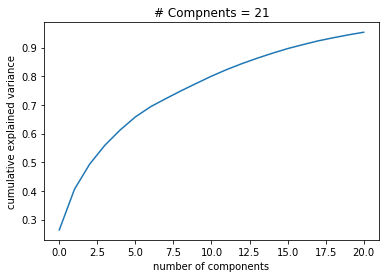

In [78]:
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("# Compnents = " + str(pca.n_components_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [79]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [80]:
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
res.summary()
#

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               ems_call   No. Observations:                 3240
Model:                            GLM   Df Residuals:                     3219
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4359.2
Date:                Mon, 10 Feb 2020   Deviance:                       78686.
Time:                        21:26:01   Pearson chi2:                 5.45e+03
No. Iterations:                     9   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0636      0.006    -11.026      0.000      -0.075      -0.052
x2            -0.0262      0.007     -3.496      0.000      -0.041      -0.012
x3             0.0140      0.009      1.577      0.115      -0.003       0.031
x4            -0.1911      0.011    -18.005      0.000      -0.212      -0.170
x5             0.1168      0.013      8.781      0.000       0.091       0.143
x6             0.0351      0.013      2.612      0.009       0.009       0.061
x7            -0.0104      0.014     -0.748      0.454      -0.038       0.017
x8             0.0697      0.017      4.188      0.000       0.037       0.102
x9             0.0620      0.016      3.803      0.000       0.030       0.094
x10           -0.0250      0.018     -1.425      0.154      -0.059       0.009
x11            0.1153      0.018      6.449      0.000       0.080       0.150
x12           -0.0115      0.017     -0.665      0.506      -0.046       0.022
x13           -0.1234      0.021     -5.767      0.000      -0.165      -0.081
x14            0.0069      0.021      0.333      0.739      -0.034       0.047
x15            0.0071      0.021      0.332      0.740      -0.035       0.049
x16           -0.0073      0.021     -0.355      0.723      -0.048       0.033
x17            0.0463      0.025      1.877      0.060      -0.002       0.095
x18            0.0595      0.025      2.375      0.018       0.010       0.109
x19            0.0411      0.030      1.358      0.174      -0.018       0.100
x20            0.0481      0.026      1.817      0.069      -0.004       0.100
x21            0.0628      0.032      1.946      0.052      -0.000       0.126
==============================================================================
"""

In [83]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_ratio_)


loadings = pd.DataFrame(loadings)



for i in range(len(loadings.columns)):
    loadings.rename(columns={loadings.columns[i]: "X"+str(i+1)}, inplace=True)

loadings.set_index(X.columns, inplace=True)


important_features = loadings.filter(['X3', 'X7', 'X10','X12','X14','X15','X16','X19'])

X14 = important_features.X14.sort_values(ascending=False)[0:20]
X14

pct_Civ_unemp_45_64_ACS_13_17    0.091448
pct_NoHealthIns_65P_ACS_13_17    0.051264
Median_Age_ACS_13_17             0.036566
pct_College_ACS_13_17            0.036497
pct_Pop_65plus_ACS_13_17         0.022544
HospiceCount2mi                  0.018023
Civ_labor_16_24_ACS_13_17        0.015176
pct_Males_ACS_13_17              0.011730
HospitalsPsychCount2mi           0.010030
DrugDropCount2mi                 0.007704
Civ_labor_16plus_ACS_13_17       0.006486
pct_Civ_unemp_16_24_ACS_13_17    0.006255
NaloxoneDistribCount2mi          0.004951
pct_Pop_18_24_ACS_13_17          0.004660
HospitalsGeneralCount2mi         0.004572
pct_Prs_Blw_Pov_Lev_ACS_13_17    0.003554
MentalFacilitiesCount2mi         0.003254
Civ_labor_45_64_ACS_13_17        0.002877
WomensClinicsCount2mi            0.002413
HospitalsChildCount2mi           0.002106
Name: X14, dtype: float64

In [84]:
X15 = important_features.X15.sort_values(ascending=False)[0:20]
X15

pct_Civ_unemp_16_24_ACS_13_17    0.102112
pct_Males_ACS_13_17              0.040024
pct_NH_AIAN_alone_ACS_13_17      0.021196
pct_NoHealthIns_65P_ACS_13_17    0.020358
pct_One_Health_Ins_ACS_13_17     0.018884
Median_Age_ACS_13_17             0.015126
PainManagementCount2mi           0.014091
PharmCount2mi                    0.011566
HospitalsPsychCount2mi           0.010123
pct_College_ACS_13_17            0.009275
PhysicalTherapyCount2mi          0.007394
UrgentCareCount2mi               0.007332
pct_NH_White_alone_ACS_13_17     0.005599
HospitalsGeneralCount2mi         0.003387
Civ_labor_45_64_ACS_13_17        0.002789
SubstanceAbuseCount2mi           0.000710
year_month                       0.000629
pct_Pop_18_24_ACS_13_17          0.000080
mhi                              0.000000
WomensClinicsCount2mi           -0.000423
Name: X15, dtype: float64

In [85]:
X16 = important_features.X16.sort_values(ascending=False)[0:20]
X16

DrugDropCount2mi                 0.030437
ChildFacilitiesCount2mi          0.029936
NursingAssistedLiveCount2mi      0.028566
pct_Males_ACS_13_17              0.028104
Civ_labor_25_44_ACS_13_17        0.021024
pct_College_ACS_13_17            0.016937
HospiceCount2mi                  0.016071
MentalFacilitiesCount2mi         0.015616
pct_Prs_Blw_Pov_Lev_ACS_13_17    0.013373
HospitalsPsychCount2mi           0.010887
NaloxoneDistribCount2mi          0.006847
pct_Civ_unemp_16_24_ACS_13_17    0.006580
Civ_labor_16plus_ACS_13_17       0.005492
HospitalsGeneralCount2mi         0.004999
HospitalsChildCount2mi           0.003496
SubstanceAbuseCount2mi           0.000423
mhi                              0.000000
Civ_labor_16_24_ACS_13_17       -0.001833
OtherMedicalFacilitesCount2mi   -0.002322
pct_NH_AIAN_alone_ACS_13_17     -0.002917
Name: X16, dtype: float64

In [86]:
X7 = important_features.X7.sort_values(ascending=False)[0:20]
X7

pct_NoHealthIns_65P_ACS_13_17    0.063017
pct_Males_ACS_13_17              0.052366
pct_Not_HS_Grad_ACS_13_17        0.052278
Civ_labor_16_24_ACS_13_17        0.044788
pct_Pop_18_24_ACS_13_17          0.040749
pct_NH_White_alone_ACS_13_17     0.033167
HospitalsPsychCount2mi           0.022504
HospiceCount2mi                  0.016617
NursingAssistedLiveCount2mi      0.014897
Median_Age_ACS_13_17             0.013091
pct_NH_AIAN_alone_ACS_13_17      0.013063
pct_Pop_65plus_ACS_13_17         0.012889
HospitalsGeneralCount2mi         0.010212
HospitalsChildCount2mi           0.007207
WomensClinicsCount2mi            0.005475
pct_Prs_Blw_Pov_Lev_ACS_13_17    0.004423
PhysicalTherapyCount2mi          0.004364
MentalFacilitiesCount2mi         0.001007
Civ_labor_45_64_ACS_13_17        0.000187
SurgicalCentersCount2mi          0.000138
Name: X7, dtype: float64

In [87]:
X12 = important_features.X12.sort_values(ascending=False)[0:20]
X12

pct_NoHealthIns_65P_ACS_13_17    0.085804
pct_Not_HS_Grad_ACS_13_17        0.027767
pct_College_ACS_13_17            0.025025
Civ_labor_25_44_ACS_13_17        0.021495
pct_Males_ACS_13_17              0.017460
PhysicalTherapyCount2mi          0.011634
DrugDropCount2mi                 0.009269
SurgicalCentersCount2mi          0.006893
year_month                       0.006750
PainManagementCount2mi           0.006650
MentalFacilitiesCount2mi         0.005469
HospitalsChildCount2mi           0.005011
pct_NH_White_alone_ACS_13_17     0.003299
SubstanceAbuseCount2mi           0.003190
UrgentCareCount2mi               0.000299
mhi                              0.000000
ChildFacilitiesCount2mi         -0.000369
HospitalsGeneralCount2mi        -0.001226
pct_PUB_ASST_INC_ACS_13_17      -0.001443
OtherMedicalFacilitesCount2mi   -0.002161
Name: X12, dtype: float64

In [102]:
mask = np.random.rand(len(cin_gdf_standard)) < 0.8
print(cin_gdf_standard.columns)
#print(cin_train.isnull().values.any())
cin_train = cin_gdf_standard[mask]
cin_test = cin_gdf_standard[~mask]
cin_train.dropna(inplace=True)
cin_test.dropna(inplace=True)
print('Training data set length='+str(len(cin_train)))
print('Testing data set length='+str(len(cin_test)))
y_train, X_train = cin_train.ems_call, cin_train
X_train.drop(columns='ems_call', inplace=True)

X_train=X_train[['pct_NoHealthIns_65P_ACS_13_17','Civ_labor_25_44_ACS_13_17','pct_Males_ACS_13_17','pct_Not_HS_Grad_ACS_13_17','pct_College_ACS_13_17','Civ_labor_16_24_ACS_13_17','DrugDropCount2mi','NursingAssistedLiveCount2mi','pct_Civ_unemp_16_24_ACS_13_17','pct_Civ_unemp_45_64_ACS_13_17','Median_Age_ACS_13_17','HospitalsPsychCount2mi','HospiceCount2mi','ChildFacilitiesCount2mi','PainManagementCount2mi']]
X_test=X_test[['pct_NoHealthIns_65P_ACS_13_17','Civ_labor_25_44_ACS_13_17','pct_Males_ACS_13_17','pct_Not_HS_Grad_ACS_13_17','pct_College_ACS_13_17','Civ_labor_16_24_ACS_13_17','DrugDropCount2mi','NursingAssistedLiveCount2mi','pct_Civ_unemp_16_24_ACS_13_17','pct_Civ_unemp_45_64_ACS_13_17','Median_Age_ACS_13_17','HospitalsPsychCount2mi','HospiceCount2mi','ChildFacilitiesCount2mi','PainManagementCount2mi']]


y_test, X_test = cin_test.ems_call, cin_test
X_test.drop(columns='ems_call', inplace=True)


res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
res.summary()
#

Index(['HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi',
       'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'Median_Age_ACS_13_17',
       'pct_College_ACS_13_17', 'pct_Not_HS_Grad_ACS_13_17',
       'pct_NoHealthIns_65P_ACS_13_17', 'pct_NH_White_alone_ACS_13_17',
       'pct_NH_AIAN_alone_ACS_13_17', 'pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17', 'pct_Pop_65plus_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17', 'pct_One_Health_Ins_ACS_13_17',
       'Civ_labor_16plus_ACS_13_17', 'Civ_labor_16_24_ACS_13_17',
       'pct_Civ_unemp_16_24_ACS_13_17', 'Civ_labor_25_44_ACS_13_17',
       'Civ_labor_45_6

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               ems_call   No. Observations:                 3255
Model:                            GLM   Df Residuals:                     3240
Model Family:                 Poisson   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4403.8
Date:                Mon, 10 Feb 2020   Deviance:                       79062.
Time:                        22:05:35   Pearson chi2:                 5.52e+03
No. Iterations:                     7   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_NoHealthIns_65P_ACS_13_17     0.0021      0.017      0.125      0.901      -0.032       0.036
Civ_labor_25_44_ACS_13_17        -0.0044      0.020     -0.223      0.823      -0.043       0.034
pct_Males_ACS_13_17               0.0501      0.017      2.974      0.003       0.017       0.083
pct_Not_HS_Grad_ACS_13_17        -0.0305      0.027     -1.115      0.265      -0.084       0.023
pct_College_ACS_13_17            -0.0639      0.025     -2.555      0.011      -0.113      -0.015
Civ_labor_16_24_ACS_13_17         0.0280      0.019      1.473      0.141      -0.009       0.065
DrugDropCount2mi                 -0.1122      0.023     -4.899      0.000      -0.157      -0.067
NursingAssistedLiveCount2mi      -0.0178      0.021     -0.840      0.401      -0.059       0.024
pct_Civ_unemp_16_24_ACS_13_17    -0.0151      0.019     -0.782      0.434      -0.053       0.023
pct_Civ_unemp_45_64_ACS_13_17     0.0349      0.019      1.885      0.059      -0.001       0.071
Median_Age_ACS_13_17              0.0706      0.022      3.269      0.001       0.028       0.113
HospitalsPsychCount2mi           -0.0474      0.025     -1.898      0.058      -0.096       0.002
HospiceCount2mi                  -0.0630      0.024     -2.607      0.009      -0.110      -0.016
ChildFacilitiesCount2mi           0.1653      0.018      9.324      0.000       0.131       0.200
PainManagementCount2mi            0.3518      0.026     13.334      0.000       0.300       0.404
=================================================================================================
"""

In [103]:
X_train.corr()

,pct_NoHealthIns_65P_ACS_13_17,Civ_labor_25_44_ACS_13_17,pct_Males_ACS_13_17,pct_Not_HS_Grad_ACS_13_17,pct_College_ACS_13_17,Civ_labor_16_24_ACS_13_17,DrugDropCount2mi,NursingAssistedLiveCount2mi,pct_Civ_unemp_16_24_ACS_13_17,pct_Civ_unemp_45_64_ACS_13_17,Median_Age_ACS_13_17,HospitalsPsychCount2mi,HospiceCount2mi,ChildFacilitiesCount2mi,PainManagementCount2mi
pct_NoHealthIns_65P_ACS_13_17,1.000000,0.025196,0.013639,0.193170,0.000653,0.270560,0.002026,0.008762,-0.022239,-0.049809,-0.181866,0.026221,0.057490,0.046822,0.095614
Civ_labor_25_44_ACS_13_17,0.025196,1.000000,0.008241,-0.347477,0.342093,0.318717,-0.108859,0.000496,-0.248065,-0.240516,-0.010898,0.141946,0.043682,-0.039415,-0.032548
pct_Males_ACS_13_17,0.013639,0.008241,1.000000,0.020826,0.094944,0.163147,0.018318,-0.055930,-0.094378,0.040546,-0.041259,-0.067269,0.069584,0.048005,0.192604
pct_Not_HS_Grad_ACS_13_17,0.193170,-0.347477,0.020826,1.000000,-0.626806,-0.173440,0.075953,-0.005757,0.388340,0.412070,-0.308623,-0.047133,0.034595,0.044389,0.119831
pct_College_ACS_13_17,0.000653,0.342093,0.094944,-0.626806,1.000000,0.191436,-0.016478,0.033026,-0.372277,-0.229028,-0.062506,0.057676,0.036036,-0.077762,-0.049348
Civ_labor_16_24_ACS_13_17,0.270560,0.318717,0.163147,-0.173440,0.191436,1.000000,-0.056830,-0.046455,-0.153831,-0.120511,-0.392041,-0.036863,0.046502,0.075644,0.062840
DrugDropCount2mi,0.002026,-0.108859,0.018318,0.075953,-0.016478,-0.056830,1.000000,0.143340,0.082685,0.136360,0.007959,-0.352118,-0.040379,0.149558,0.535024
NursingAssistedLiveCount2mi,0.008762,0.000496,-0.055930,-0.005757,0.033026,-0.046455,0.143340,1.000000,0.003109,0.002614,0.041014,0.081823,-0.070624,-0.442107,-0.222539
pct_Civ_unemp_16_24_ACS_13_17,-0.022239,-0.248065,-0.094378,0.388340,-0.372277,-0.153831,0.082685,0.003109,1.000000,0.342517,-0.106886,-0.062815,-0.065023,0.024095,0.045361
pct_Civ_unemp_45_64_ACS_13_17,-0.049809,-0.240516,0.040546,0.412070,-0.229028,-0.120511,0.136360,0.002614,0.342517,1.000000,-0.204142,-0.061828,0.005840,0.048439,0.102945


In [65]:
np.exp(res.params)

HospitalsGeneralCount2mi    1.249953
HospitalsPsychCount2mi      0.853246
SurgicalCentersCount2mi     1.105422
UrgentCareCount2mi          0.668669
PainManagementCount2mi      1.546365
                              ...   
Tract_26900.0               0.617636
Tract_27000.0               0.490767
Tract_27100.0               1.008221
Tract_27200.0               0.964462
Tract_27400.0               0.085534
Length: 151, dtype: float64

In [66]:
poisson_predictions = res.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,5.022574,0.389917,4.313652,5.848002
2,9.168130,0.708716,7.879181,10.667938
25,1.105016,0.319365,0.627133,1.947053
37,5.428966,1.087214,3.666521,8.038596
38,5.038958,1.009136,3.403089,7.461191


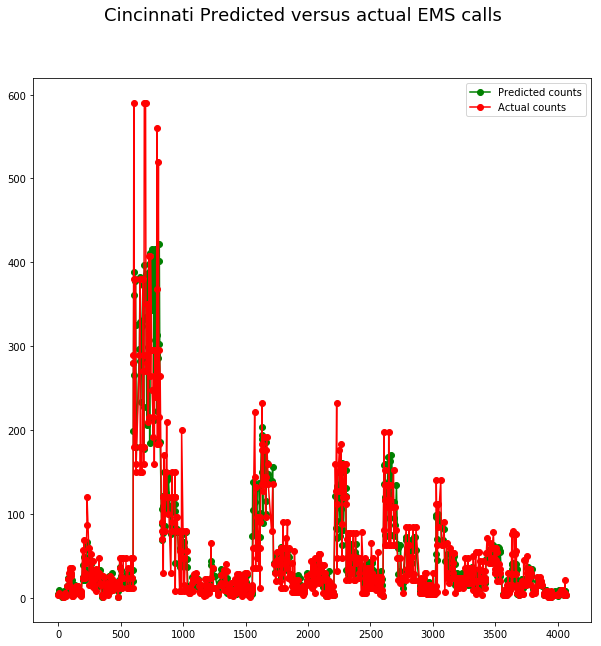

<Figure size 432x288 with 0 Axes>

In [67]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test
fig = plt.figure(figsize=(10,10))
fig.suptitle('Cincinnati Predicted versus actual EMS calls', size=18)
predicted, = plt.plot(predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()
plt.savefig('Cincy_EMS_poisson')

Text(0, 0.5, 'frequency')

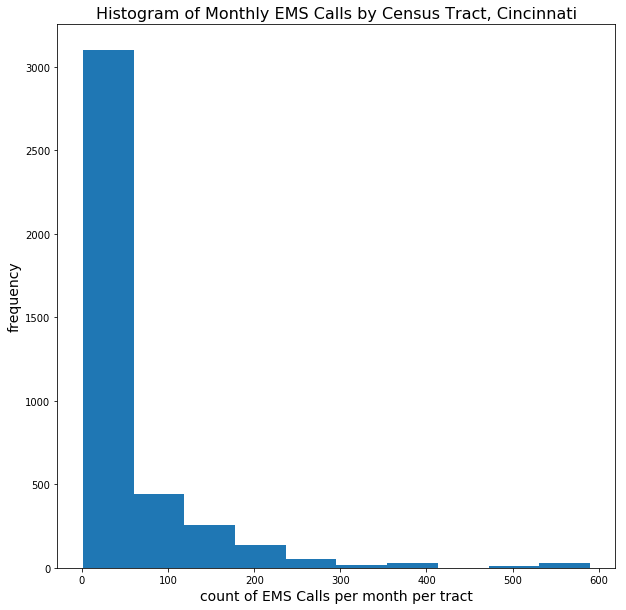

In [68]:
plt.figure(figsize=(10,10))
plt.hist(cin_gdf.ems_call)
plt.title('Histogram of Monthly EMS Calls by Census Tract, Cincinnati', size=16)
plt.xlabel('count of EMS Calls per month per tract', size=14)
plt.ylabel('frequency', size=14)

In [53]:
var = ['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi', 'SurgicalCentersCount2mi',
       'UrgentCareCount2mi', 'WomensClinicsCount2mi', 'PainManagementCount2mi','PhysicalTherapyCount2mi'
       'MentalFacilitiesCount2mi', 'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi', 
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi', 'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi',
       'PharmCount2mi', 'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'Med_HHD_Inc_ACS_13_17',
       'pct_College_ACS_13_17', 'pct_Males_ACS_13_17', 'pct_Pop_18_24_ACS_13_17', 'pct_Pop_25_44_ACS_13_17', 'year_month',
       'ems_call']


### Logit

In [69]:
dfl=cin_gdf_1
#dfl.dropna(inplace=True)
#dfl = cin_gdf.filter(var)

In [70]:
dfl.head()
print(np.median(dfl['ems_call']))
print(dfl.ems_call[3])
print(dfl.ems_call)

24.0
6
0        3
1        3
2        6
3        6
4       18
        ..
4065     6
4066     3
4067     6
4068     3
4069     6
Name: ems_call, Length: 4070, dtype: int64


In [71]:
dfl['ems_flag'] = 0 
median=np.median(dfl['ems_call'])

In [72]:
for i in range(len(dfl)):
    if i in dfl.index and dfl.ems_call[i] >= median:
        dfl.ems_flag[i] = 1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
dfl.ems_flag.value_counts()

1    2158
0    1912
Name: ems_flag, dtype: int64

(array([1912.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2158.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

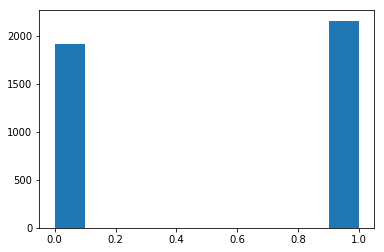

In [74]:
plt.hist(dfl.ems_flag)

In [75]:
np.median(dfl.ems_call)

24.0

(array([3101.,  445.,  254.,  136.,   54.,   18.,   26.,    0.,    8.,
          28.]),
 array([  1. ,  59.9, 118.8, 177.7, 236.6, 295.5, 354.4, 413.3, 472.2,
        531.1, 590. ]),
 <a list of 10 Patch objects>)

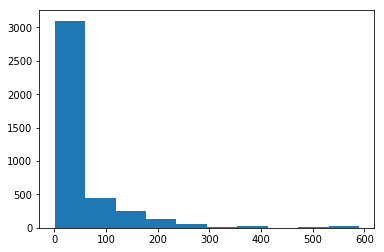

In [76]:
plt.hist(dfl.ems_call)

In [77]:
dfl.dropna(inplace=True)
yl = dfl.ems_flag
print(yl)
Xl = dfl

0       0
1       0
2       0
3       0
4       0
       ..
4065    0
4066    0
4067    0
4068    0
4069    0
Name: ems_flag, Length: 4058, dtype: int64


In [78]:
Xl.drop('ems_flag', inplace=True, axis=1)

In [79]:
#Xl.dropna(inplace=True)
#print(Xl.columns)
"""for i in range(24):
    print (Xl.iloc[:,i].unique())"""
"""for col in Xl:
    print Xl[col].unique()"""
Xl_exp=Xl.iloc[:,:24]

In [80]:
res = sm.Logit(yl, Xl_exp).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.557239
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ems_flag   No. Observations:                 4058
Model:                          Logit   Df Residuals:                     4034
Method:                           MLE   Df Model:                           23
Date:                Wed, 05 Feb 2020   Pseudo R-squ.:                  0.1939
Time:                        19:39:55   Log-Likelihood:                -2261.3
converged:                       True   LL-Null:                       -2805.3
                                        LLR p-value:                2.382e-215
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
HospitalsGeneralCount2mi          0.5119      0.047     10.805      0.000       0.419       0.605
HospitalsPsychCount2mi           -0.4448      0.145     -3.077      0.002      -0.728      -0.161
SurgicalCentersCount2mi           0.1869      0.040      4.686      0.000       0.109       0.265
UrgentCareCount2mi               -0.6109      0.069     -8.913      0.000      -0.745      -0.477
PainManagementCount2mi            0.8419      0.102      8.288      0.000       0.643       1.041
MentalFacilitiesCount2mi         -0.4895      0.058     -8.462      0.000      -0.603      -0.376
NursingAssistedLiveCount2mi       0.0738      0.019      3.989      0.000       0.038       0.110
HospiceCount2mi                   0.3035      0.091      3.337      0.001       0.125       0.482
ChildFacilitiesCount2mi           1.0038      0.090     11.094      0.000       0.826       1.181
DrugDropCount2mi                 -0.1416      0.058     -2.433      0.015      -0.256      -0.028
NaloxoneDistribCount2mi          -0.0275      0.012     -2.312      0.021      -0.051      -0.004
Median_Age_ACS_13_17             -0.0010      0.006     -0.149      0.882      -0.014       0.012
pct_College_ACS_13_17            -0.0110      0.003     -3.740      0.000      -0.017      -0.005
pct_Not_HS_Grad_ACS_13_17         0.0067      0.007      0.934      0.350      -0.007       0.021
pct_NoHealthIns_65P_ACS_13_17    -0.0222      0.014     -1.575      0.115      -0.050       0.005
pct_NH_White_alone_ACS_13_17     -0.0015      0.002     -0.790      0.430      -0.005       0.002
pct_NH_AIAN_alone_ACS_13_17       0.0842      0.076      1.115      0.265      -0.064       0.232
pct_Males_ACS_13_17               0.0444      0.008      5.398      0.000       0.028       0.061
pct_Pop_18_24_ACS_13_17           0.0123      0.004      2.923      0.003       0.004       0.021
pct_Prs_Blw_Pov_Lev_ACS_13_17    -0.0168      0.004     -3.793      0.000      -0.025      -0.008
pct_One_Health_Ins_ACS_13_17     -0.0295      0.005     -6.162      0.000      -0.039      -0.020
pct_Civ_unemp_16_24_ACS_13_17     0.0040      0.003      1.323      0.186      -0.002       0.010
Civ_labor_25_44_ACS_13_17         0.0001      0.000      0.980      0.327      -0.000       0.000
pct_Civ_unemp_45_64_ACS_13_17    -0.0149      0.006     -2.335      0.020      -0.027      -0.002
=================================================================================================
"""

In [647]:
np.exp(res.params)

HospitalsGeneralCount2mi         1.653687
HospitalsPsychCount2mi           0.638449
SurgicalCentersCount2mi          1.213998
UrgentCareCount2mi               0.532870
PainManagementCount2mi           2.365555
MentalFacilitiesCount2mi         0.610318
NursingAssistedLiveCount2mi      1.083400
HospiceCount2mi                  1.339966
ChildFacilitiesCount2mi          2.806641
DrugDropCount2mi                 0.862089
NaloxoneDistribCount2mi          0.974964
Median_Age_ACS_13_17             0.994669
pct_College_ACS_13_17            0.988816
pct_Not_HS_Grad_ACS_13_17        1.010046
pct_NoHealthIns_65P_ACS_13_17    0.975236
pct_NH_White_alone_ACS_13_17     0.998676
pct_NH_AIAN_alone_ACS_13_17      1.077635
pct_Males_ACS_13_17              1.046748
pct_Pop_18_24_ACS_13_17          1.009604
pct_Prs_Blw_Pov_Lev_ACS_13_17    0.983733
pct_One_Health_Ins_ACS_13_17     0.973757
pct_Civ_unemp_16_24_ACS_13_17    1.005158
pct_Civ_unemp_45_64_ACS_13_17    0.987970
pct_PUB_ASST_INC_ACS_13_17       0

In [648]:
df3 = cin_gdf.corr()

In [649]:
df4 = pd.DataFrame(df3['ems_call'])

In [650]:
df4[:21]

,ems_call
CensusTract,-0.313467
HospitalsGeneralCount2mi,0.133426
HospitalsPsychCount2mi,-0.128839
SurgicalCentersCount2mi,0.053537
UrgentCareCount2mi,0.067375
WomensClinicsCount2mi,0.184182
PainManagementCount2mi,0.465360
PhysicalTherapyCount2mi,0.081933
MentalFacilitiesCount2mi,0.189462
SubstanceAbuseCount2mi,0.188836


In [651]:
fac_cv = fac

In [652]:
fac_cv.drop(['CensusTract', 'geometry'], axis=1, inplace=True)

In [653]:
fac_cv.corr()

,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi
HospitalsGeneralCount2mi,1.000000,-0.050861,0.524646,0.239114,0.789320,0.479889,0.605575,0.875588,0.874814,0.869846,0.254970,0.192215,0.870782,0.113116,0.798115,0.583568,0.590719
HospitalsPsychCount2mi,-0.050861,1.000000,0.239559,0.320285,-0.340792,-0.109352,0.030451,-0.167272,-0.330623,-0.218243,0.086510,0.434665,-0.277636,-0.143933,-0.179874,-0.398126,-0.163773
SurgicalCentersCount2mi,0.524646,0.239559,1.000000,0.689255,0.196868,0.256229,0.612565,0.516155,0.408507,0.433569,0.401352,0.293874,0.445081,-0.072625,0.390919,0.223824,0.269658
UrgentCareCount2mi,0.239114,0.320285,0.689255,1.000000,-0.032461,0.406462,0.572403,0.166696,0.143654,0.197886,0.340390,0.220017,0.076753,0.008957,0.390052,0.013893,0.317820
WomensClinicsCount2mi,0.789320,-0.340792,0.196868,-0.032461,1.000000,0.471689,0.463273,0.745741,0.828167,0.870911,0.024375,-0.047493,0.718350,0.290520,0.734940,0.525049,0.491820
PainManagementCount2mi,0.479889,-0.109352,0.256229,0.406462,0.471689,1.000000,0.617746,0.509073,0.584625,0.631693,-0.034100,0.216013,0.337021,0.463310,0.655481,0.410886,0.306703
PhysicalTherapyCount2mi,0.605575,0.030451,0.612565,0.572403,0.463273,0.617746,1.000000,0.589413,0.660610,0.588826,0.415324,0.170470,0.587645,-0.035464,0.603277,0.335971,0.368173
MentalFacilitiesCount2mi,0.875588,-0.167272,0.516155,0.166696,0.745741,0.509073,0.589413,1.000000,0.902296,0.861444,0.189715,0.124904,0.860917,0.239964,0.751826,0.695414,0.444921
SubstanceAbuseCount2mi,0.874814,-0.330623,0.408507,0.143654,0.828167,0.584625,0.660610,0.902296,1.000000,0.907654,0.158804,0.037761,0.890829,0.238242,0.843760,0.699247,0.516618
OtherMedicalFacilitesCount2mi,0.869846,-0.218243,0.433569,0.197886,0.870911,0.631693,0.588826,0.861444,0.907654,1.000000,0.037869,0.163071,0.770799,0.397127,0.825525,0.570479,0.565631


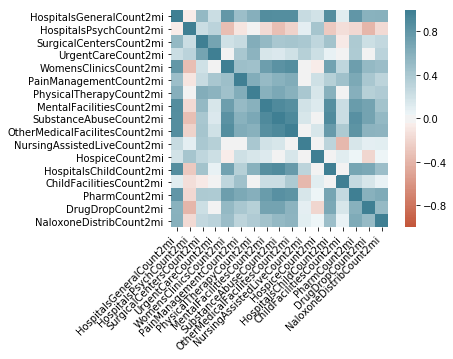

In [89]:
corr = fac.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [90]:
from sklearn.decomposition import PCA

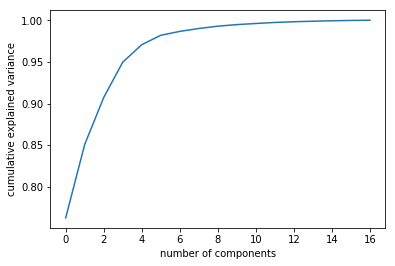

In [93]:
pca = PCA().fit(fac_cv.values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [96]:
pca_fac = PCA(n_components=2).fit(fac_cv.values)

In [100]:
fac_pca = pd.DataFrame(pca_fac.components_)

In [102]:
fac_pca = fac_pca.T

In [103]:
fac_pca

,0,1
0,0.166887,-0.028480
1,-0.008628,0.005119
2,0.083134,0.000616
3,0.038350,0.127180
4,0.071137,-0.050367
5,0.038401,-0.020975
6,0.054355,0.000802
7,0.132376,-0.100664
8,0.191209,-0.100714
9,0.705516,-0.479155


In [95]:
PCA?

In [84]:
fac_cv.columns

Index(['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi',
       'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'geometry'],
      dtype='object')

,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,...,Tract_26400,Tract_26500,Tract_26600,Tract_26700,Tract_26800,Tract_26900,Tract_27000,Tract_27100,Tract_27200,Tract_27400
0,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
1,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
2,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
3,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
4,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
5,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
6,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
7,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
8,2,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
9,2,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ge_ACS_13_17	-0.178175
pct_Males_ACS_13_17	0.207492
pct_Pop_18_24_ACS_13_17	-0.070584
pct_Pop_25_44_ACS_13

In [108]:
cen_corr = cin_gdf.filter(['pct_College_ACS_13_17', 'pct_Males_ACS_13_17', 
                'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17'])

In [109]:
cen_corr.corr()

,pct_College_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17
pct_College_ACS_13_17,1.000000,0.219176,0.165182,0.524993
pct_Males_ACS_13_17,0.219176,1.000000,0.414221,0.156665
pct_Pop_18_24_ACS_13_17,0.165182,0.414221,1.000000,-0.319997
pct_Pop_25_44_ACS_13_17,0.524993,0.156665,-0.319997,1.000000


In [111]:
df4[:21]

,ems_call
HospitalsGeneralCount2mi,0.137245
HospitalsPsychCount2mi,-0.029317
SurgicalCentersCount2mi,-0.062300
UrgentCareCount2mi,-0.118978
WomensClinicsCount2mi,0.172335
PainManagementCount2mi,0.257200
PhysicalTherapyCount2mi,-0.001588
MentalFacilitiesCount2mi,0.099455
SubstanceAbuseCount2mi,0.102888
OtherMedicalFacilitesCount2mi,0.210124


In [117]:
pkl_in_Cin = open('cin_pkl', 'rb')

cin = pickle.load(pkl_in_Cin)
print(cin)

      index  CensusTract  HospitalsGeneralCount2mi  HospitalsPsychCount2mi  \
0         0       5200.0                         3                       1   
1         1       5200.0                         3                       1   
2         2       5200.0                         3                       1   
3         3       5200.0                         3                       1   
4         4       5200.0                         3                       1   
...     ...          ...                       ...                     ...   
1233   1233       5000.0                         2                       0   
1234   1234       5000.0                         2                       0   
1235   1235       5000.0                         2                       0   
1236   1236       5100.0                         1                       0   
1237   1237       5100.0                         1                       0   

      SurgicalCentersCount2mi  UrgentCareCount2mi  WomensClinic